<font size = '4'> <center> **Using Convolutional Neural Networks for Object Localization and Classification** </center> </font>

In this notebook we are using a convolutional neural network to perform both object localization and classification. We are using the tensorflow functional api to create the model and create custom callbacks to visualize the predicted bounding boxes mid training and also reduce the learning rate.

We are using examples from the classic "Where's Waldo?" game in order to localize Waldo from an image. In order for classification we are also using another character "Wilma" and we will be classifying and localizing each character in the picture.

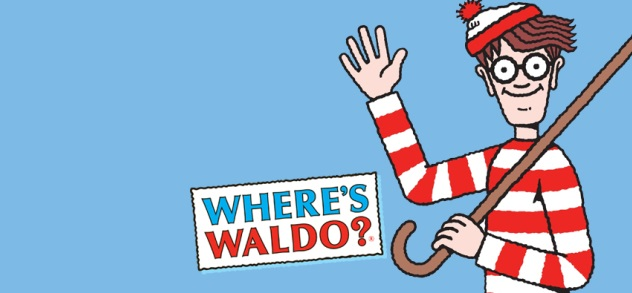

In [1]:
#first import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model

#import time
import time

2026-02-18 16:36:51.847464: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-18 16:36:51.847891: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 16:36:51.896966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 16:36:55.807723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

We will use images of Waldo, Wilma and a background image in order to synthasize example images and feed into our deep neural network. The images are created by placing either Waldo or Wilma in a random location of the background image. 

FIrst let's see the individual images of Waldo, Wilma and the background image and then let's create an example image to see what it looks like. 

In [2]:
#get the images directory
image_dir = os.getcwd() + '/images/finding_waldo'

#get the background and waldo image directory
background_dir = image_dir + '/wheres_wally.jpg'
waldo_dir = image_dir + '/waldo.png'
wilma_dir = image_dir + '/wilma.png'

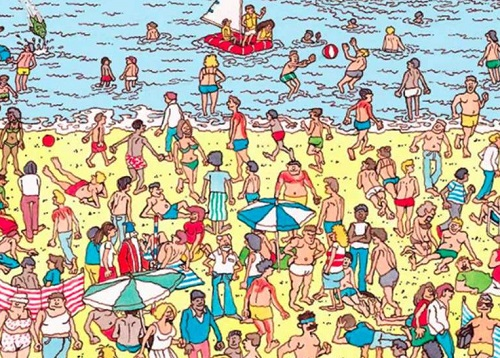

In [3]:
#background image
background_im = Image.open(background_dir)
background_im

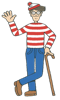

In [4]:
#image of waldo
waldo_im = Image.open(waldo_dir)
waldo_im = waldo_im.resize((60, 100))
waldo_im

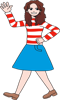

In [5]:
#wilma
wilma_im = Image.open(wilma_dir)
wilma_im = wilma_im.resize((60, 100))
wilma_im

<u> **Generating sample images** </u>

In [6]:
#create a function to generate images
def generate_sample_image():
    
    #background image
    background_im = Image.open(background_dir)
    background_im = background_im.resize((500, 350))
    #background_im = Image.new("RGB", (500, 350), (255, 255, 255))

    #waldo
    waldo_im = Image.open(waldo_dir)
    waldo_im = waldo_im.resize((60, 100))

    #wilma
    wilma_im = Image.open(wilma_dir)
    wilma_im = wilma_im.resize((60, 100))
    
    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)
    
    #pic randomly between waldo and wilma. If 1 we will select waldo. if 0 we wills elect wilma
    rand_person = np.random.choice([0, 1], p = [0.5, 0.5])
    
    if rand_person == 1:
        
        background_im.paste(waldo_im, (col, row), mask = waldo_im)
        cat = 'Waldo'
        
    else:
        
        background_im.paste(wilma_im, (col, row), mask = wilma_im)
        cat = 'Wilma'
        
    return np.array(background_im).astype('uint8'), (col, row), rand_person, cat 

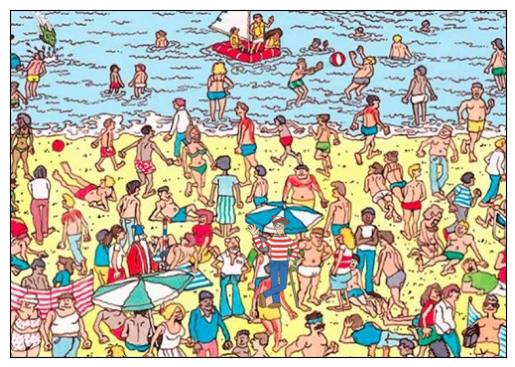

In [7]:
#generate the sample image and plot
sample_im, pos, _, cat = generate_sample_image()
plt.imshow(sample_im)
plt.xticks([])
plt.yticks([])
plt.show()

We see an example image above. In the image we will see either Waldo or Wilma is placed in a random location and we will try to use deep learning to find the location and the person (if its Wilma or Waldo).

See for yourself if you can find Waldo or Wilma in the example above.

<u> **Creating Bounding Boxes** </u>


Next we will create a function to plot a bounding box around the person. We will use a green box to show the real box about the person and we will use a red box to show the predicted location by the model. (Note that the red box in the picture below is created for illustration purposes. Later we will use the model predicted location to place the red box)

In [8]:
def plot_bounding_box(image, gt_coords, pred_coords = None):
    
    #convert image to array
    image = Image.fromarray(image)    
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)
    
    if pred_coords:
        
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)
    
    return image

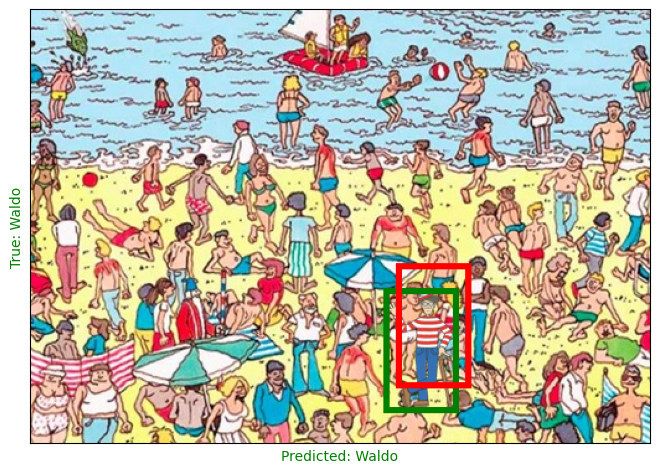

In [9]:
#generate an example image
sample_im, pos, _, cat = generate_sample_image()

#get image with bounding box
im = plot_bounding_box(sample_im, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.xlabel('Predicted: ' + cat, color = 'green')
plt.ylabel('True: ' + cat, color = 'green' )
plt.show()

<u> **Creating a function to generate data to the model** </u>

Next we will create a function to feed data to the model. Instead of creating a number of training and testing data we will create a function that feeds data continuously to the model until we reach the desired number of epochs. 

In [10]:
def generate_data(batch_size = 16):
    
    while True:
        
        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))
        
        for i in range(batch_size):
            
            #generate an example image
            sample_im, pos, person, _ = generate_sample_image()
            
            #put the images to the arrays
            x_batch[i] = sample_im/255 #normalize
            y_batch[i] = person
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]
            
        # Use x_batch directly instead of wrapping in a dict
        yield x_batch, {'class': y_batch, 'box': boundary_box}

<u> **Create the model** </u>

Here we are doing object localization and classification. So our model has to localize the position of the object we are looking for in the picture and then also identify which object is in the picture (Here we have two different people, Waldo and Wilma). 

For classification, we are using a simple classification layer. In this case we will be using a Dense Layer with a sigmoid activation. Then we will use calculate the logits using the binary classification loss function and backpropagate to learn the model parameters. 

For localization, we will be using a regression layer. We will try to predict the location of the left upper point of the bounding box (the random location we placed the images of Wilma and Waldo) using the neural network. We will use a regular Dense layer with two units and no activation. We then use the "mean squared error" to calculate the loss.  

In [11]:
#create the model
def convolutional_block(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
        
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    return x

def regression_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

def classification_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'class')(x)
    
    return x

In [12]:
from tensorflow.keras.utils import plot_model

#create the model instance
inputs = tf.keras.Input((350, 500, 3))

#conv block
x = convolutional_block(inputs)

#outputs
box_output = regression_block(x)
class_output = classification_block(x)

#model instance
model = tf.keras.Model(inputs = inputs, outputs = [class_output, box_output])

#plotting the model architechture
plot_model(model)

2026-02-18 16:37:07.161187: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [13]:
#model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 350, 500,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 350, 500,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 175, 250,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 175, 250,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 250,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 87, 125,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 82, 120,   │     73,792 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 82, 120,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 41, 60,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 36, 55,    │    147,520 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 55,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 27,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 31104)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 31,851,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 64,981,283 (247.88 MB)

 Trainable params: 64,980,931 (247.88 MB)

 Non-trainable params: 352 (1.38 KB)

<u> **Custom callbacks to visualize the predictions & reduce the learning rate** </u>

Next we will create functions to visualize our predicted bounding box & person after every two epochs and schedule the learning rate. 

In [14]:
#custom function to visualize the predictions after epochs
def test_model():
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))    
    
    for i in range(3):
        
        #get sample image
        sample_im, pos, _, cat = generate_sample_image()
        sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
        predicted_class, predicted_box = model.predict(sample_image_normalized)
        
        if predicted_class > 0.5:
            predicted_class = 'Waldo'
        else:
            predicted_class = 'Wilma'
        
        #assign color
        col = 'green' if (predicted_class == cat) else 'red'
        
        #get bounding boxes
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))
        
        #plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel('True: ' + cat, color = 'green')
        ax[i].set_xlabel('Predicted: ' + predicted_class, color = col)
        
    plt.show()
        
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model()
            
#learning rate scheduleer
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

<u> **Compile and train the model**</u>

(Note that the model fit takes about 1 hour to fully run on CPU)

In [15]:
#compile
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'class': 'binary_crossentropy', 'box': 'mse'}, \
              metrics = {'class': 'accuracy', 'box': 'mse'})

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step- box_loss: 13340.4659 - box_mse: 13340.4659 - class_accuracy: 0.5265 - class_loss: 12.7067 - loss: 13353.17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


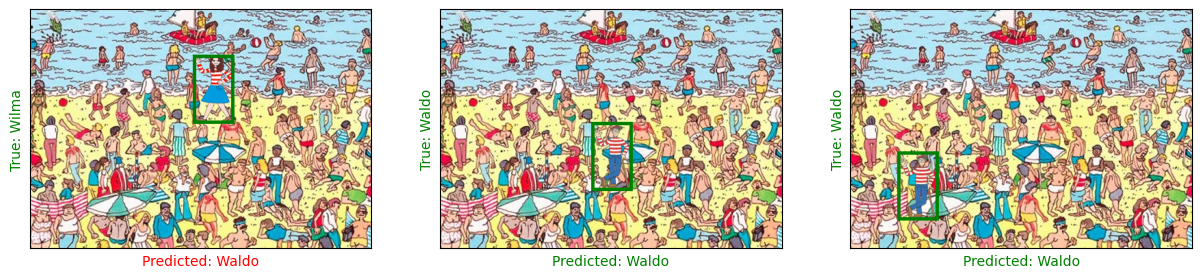

50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - box_loss: 6975.7856 - box_mse: 6975.7856 - class_accuracy: 0.4950 - class_loss: 7.1839 - loss: 6982.9688 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - box_loss: 488.4145 - box_mse: 488.4145 - class_accuracy: 0.5025 - class_loss: 1.0712 - loss: 489.4856 - learning_rate: 0.0010
Epoch 3/10
 2/50 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - box_loss: 219.3503 - box_mse: 219.3503 - class_accuracy: 0.5000 - class_loss: 0.9373 - loss: 220.2876

: 

In [16]:
#beginning time
tick = time.time()

#fit the model with reduced data load
hist = model.fit(
    generate_data(batch_size=8),  # Reduce from 16 to 8
    epochs=10, 
    steps_per_epoch=50,  # Reduce from 100 to 50
    callbacks=[VisCallback(), tf.keras.callbacks.LearningRateScheduler(lr_schedule)]
)

#end time
tock = time.time()

# Test the model after training completes
test_model()

In [20]:
#print time taken 
print('Took {} minutes to run finish training 10 epochs'.format(np.round((tock - tick)/60, 2)))

Took 54.49 minutes to run finish training 10 epochs


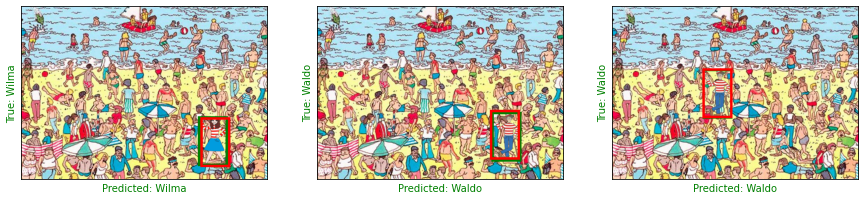

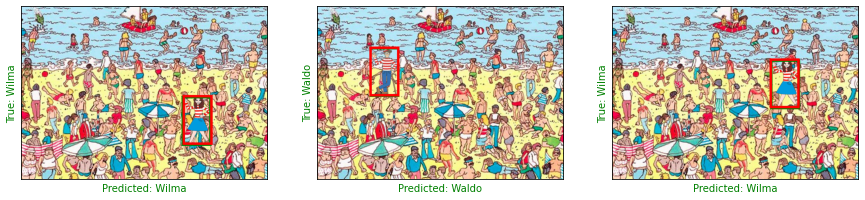

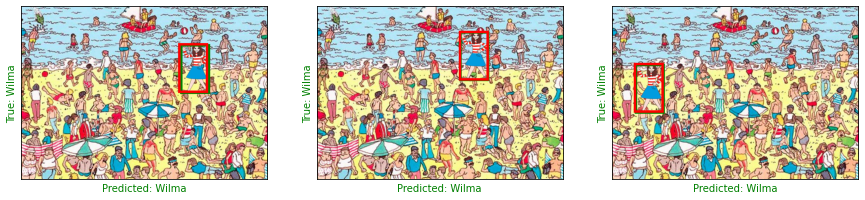

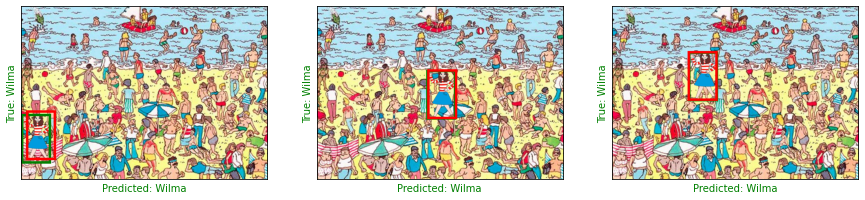

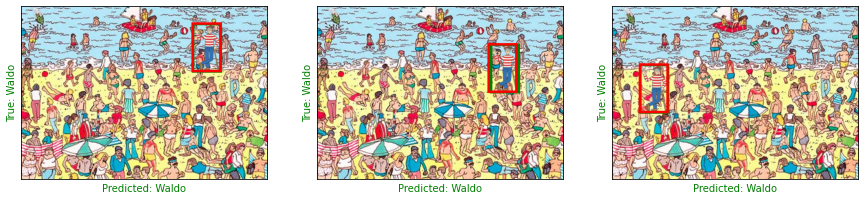

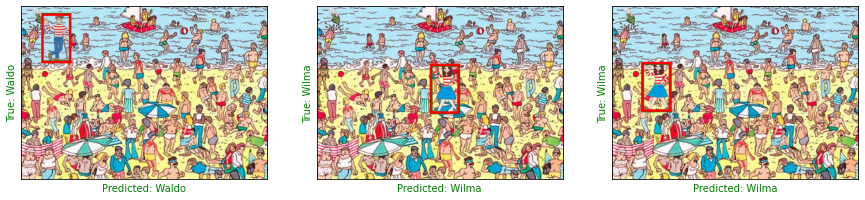

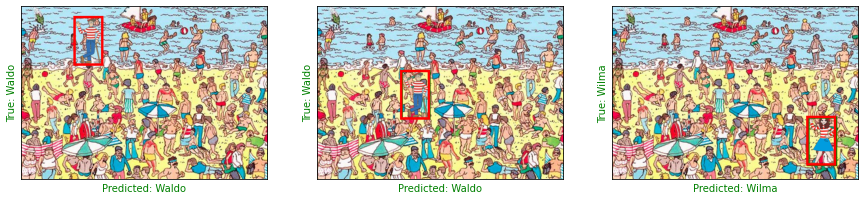

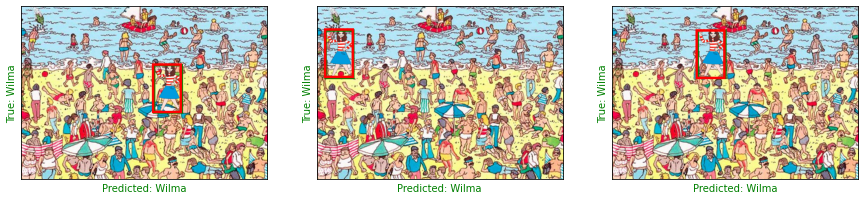

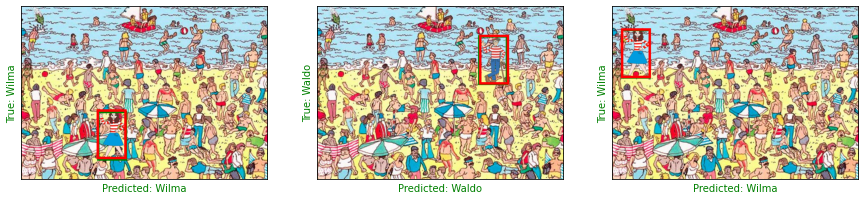

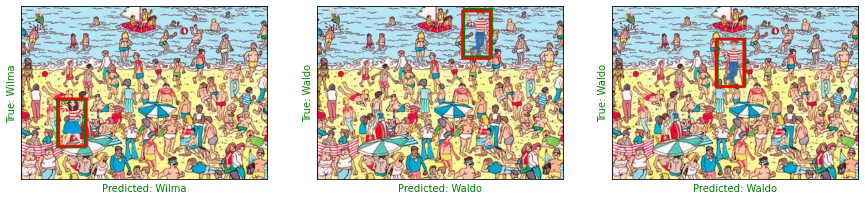

In [18]:
#test again in the end a couple of times
for i in range(10):
    test_model()

In the end we can see that the model predictions have reached an accuracy of 100% and the mean squared error of the box coordinates has reduced significantly. So when we test the model in the end we see that the model is able to predict the person and the location of the box very accurately. 